In [44]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import itertools
from PIL import Image as IMG
import nibabel as ni
import torchio as tio
import json
plt.rcParams["figure.figsize"] = (11, 11)

%matplotlib notebook
%matplotlib notebook
import math

In [41]:
obj = ni.load('test/input/local0/simulatorRun/nifti_file_S00/M02101222_swc1t1avg.nii')
arr = np.array(obj.dataobj)
# arr = np.rollaxis(arr, 2, 0)

(121, 121, 145)


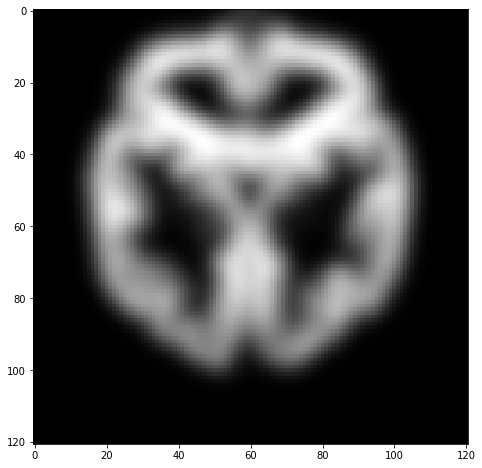

In [3]:
print(arr.shape)
plt.imshow(arr[:,:,51].squeeze(), 'gray')

In [47]:
skip = 3
x, y, z = np.where(arr>0.05)
x, y, z = x[::skip], y[::skip], z[::skip]

<IPython.core.display.Javascript object>


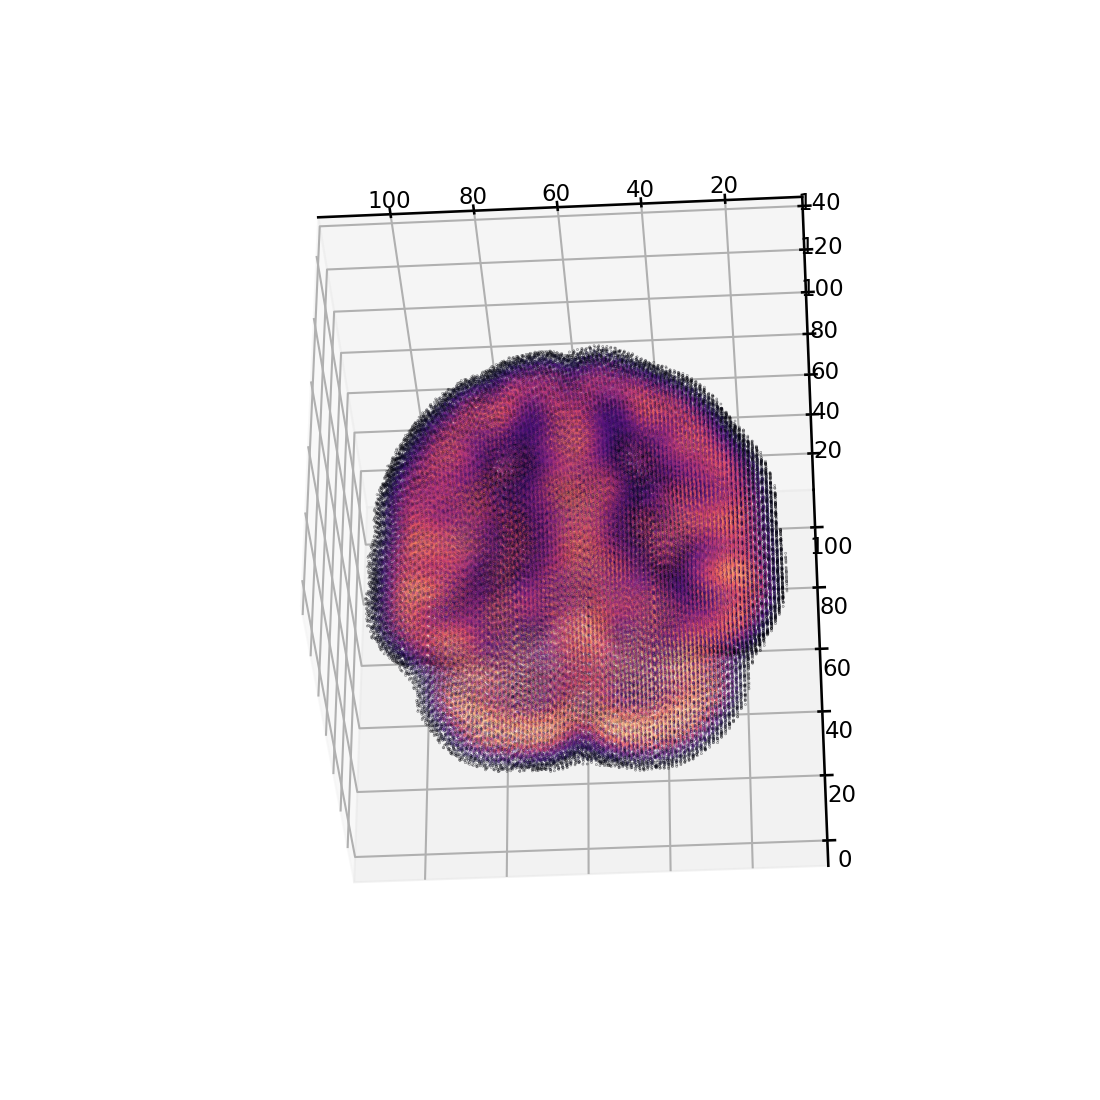

In [48]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, s=0.1, c=[arr[i, j, k] for i, j, k in zip(x, y, z)], cmap='magma')

In [5]:
prfas = glob.glob('pooled_log/*/test_metrics.csv')

In [6]:
scores = [['Experiment','Score','Value']]
epochs_pooled = []
for f in range(10):
    fdir = f'pooled_logs{os.sep}fold_{f}'
    prfa = open(fdir+os.sep+'test_metrics.csv')
    prfa.readline()
    prfa = prfa.readline()
    loss, a,f1,_,_ = [float(a) for a in prfa[1:-1].split(',')]
    scores.append(['Pooled', 'F1', f1])
    scores.append(['Pooled', 'Accuracy', a])    
    
    log = json.loads(open(fdir+os.sep+'logs.json').read())    
    epochs_pooled.append((log['best_val_epoch']))

In [7]:
epochs_dist = []
for s in range(10):
    base_dir = f'data/output/remote/simulatorRun/vbm_3d_age_classification/fold_{s}/'
    prfa = open(f'{base_dir}test_metrics.csv').readlines()[1]
    prfa = prfa.strip().split(',')
    _, f1,a, _, _ = [float(a) for a in prfa]
    scores.append(['Distributed', 'F1', f1])
    scores.append(['Distributed', 'Accuracy', a])
    
    log = json.loads(open(base_dir+os.sep+'logs.json').read()) 
    epochs_dist.append((log['best_val_epoch']))

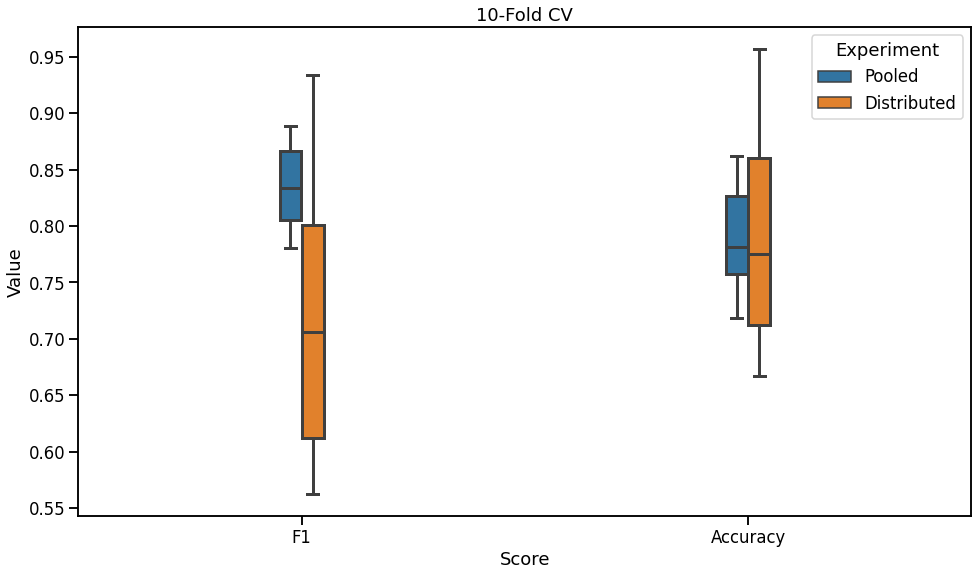

In [8]:
df = pd.DataFrame(scores[1:], columns=scores[0])
plt.rcParams['figure.figsize'] = 16, 9
sns.set_context("talk")
plt.title('10-Fold CV')
ax = sns.boxplot(x='Score', y='Value', hue='Experiment', 
                 data=df, linewidth=3, dodge=True, width=0.1)

- Batch size: 16
- Epochs: 50

### COVID19 Classification

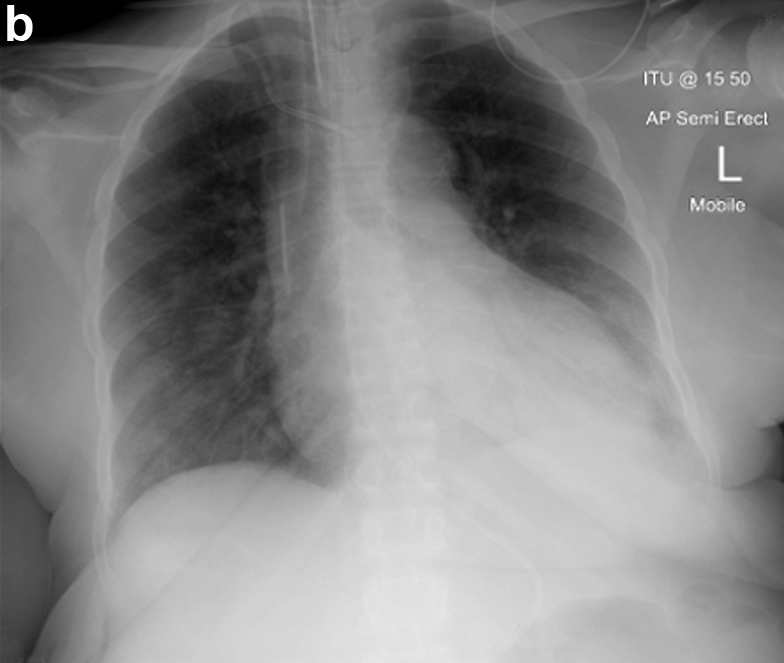

In [126]:
IMG.open('/home/ak/TrendsLab/dinunet_covid/test/input/local0/simulatorRun/data_lite0/1676210.png')

In [12]:
base_frm_scratch = '/home/ak/TrendsLab/dinunet_covid/test/output/remote/simulatorRun/covid19_from_scratch/'
base_pretrained = '/home/ak/TrendsLab/dinunet_covid/test/output/remote/simulatorRun/covid19_from_pretrained/'

In [13]:
scores, epochs_sc = [['Experiment','Score','Value']], []
epochs_dist = []
for s in range(5):
    prfa = open(f'{base_frm_scratch}/fold_{s}/test_metrics.csv').readlines()[1]
    prfa = prfa.strip().split(',')
    _, f1,a, _, _ = [float(a) for a in prfa]
    scores.append(['Distributed frm scratch', 'F1', f1])
    
    log = json.loads(open(f'{base_frm_scratch}/fold_{s}/logs.json').read()) 
    epochs_sc.append((log['best_val_epoch']))

In [14]:
epochs_pt = []
for s in range(5):
    prfa = open(f'{base_pretrained}/fold_{s}/test_metrics.csv').readlines()[1]
    prfa = prfa.strip().split(',')
    _, f1,a, _, _ = [float(a) for a in prfa]
    scores.append(['Distributed w pretrainning', 'F1', f1])
    
    log = json.loads(open(f'{base_pretrained}/fold_{s}/logs.json').read()) 
    epochs_pt.append((log['best_val_epoch']))

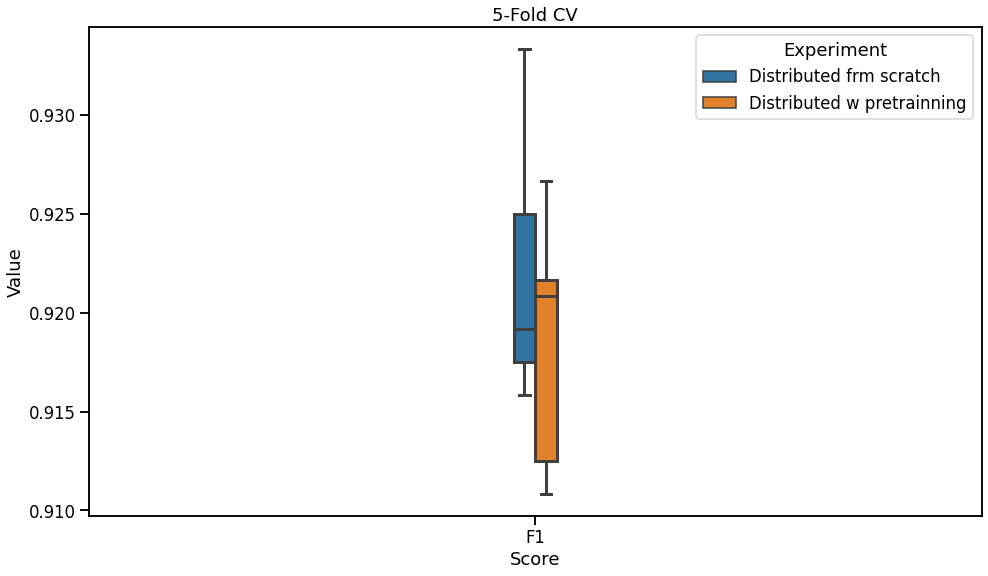

In [15]:
df = pd.DataFrame(scores[1:], columns=scores[0])
plt.rcParams['figure.figsize'] = 16, 9
sns.set_context("talk")
plt.title('5-Fold CV')
ax = sns.boxplot(x='Score', y='Value', hue='Experiment', 
                 data=df, linewidth=3, dodge=True, width=0.05)

### Average epochs while stopping criteria hit

In [129]:
print('From scratch: ', sum(epochs_sc)/len(epochs_sc))

From scratch:  30.8


In [131]:
print('With pretraining: ', sum(epochs_pt)/len(epochs_pt))

With pretraining:  17.8
